In [1]:
!wget https://gitlab.in2p3.fr/cornebize/g5k_data_non_regression/-/raw/exp_1751940/new_data/lille_2020-06-10_1751940.zip -O /tmp/archive.zip

--2020-06-10 12:23:12--  https://gitlab.in2p3.fr/cornebize/g5k_data_non_regression/-/raw/exp_1751940/new_data/lille_2020-06-10_1751940.zip
Résolution de gitlab.in2p3.fr (gitlab.in2p3.fr)… 134.158.69.41
Connexion à gitlab.in2p3.fr (gitlab.in2p3.fr)|134.158.69.41|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 3691934 (3,5M) [application/zip]
Sauvegarde en : « /tmp/archive.zip »

/tmp/archive.zip    100%[===================>]   3,52M  20,6MB/s    ds 0,2s    

2020-06-10 12:23:12 (20,6 MB/s) — « /tmp/archive.zip » sauvegardé [3691934/3691934]



In [2]:
import io
import zipfile
import pandas
import warnings
import os
import yaml
import re
import plotnine
from plotnine import *
plotnine.options.figure_size = (12, 8)
warnings.simplefilter(action='ignore')
import cashew
print(cashew.__git_version__)
from cashew import archive_extraction as ae

archives = ['/tmp/archive.zip']

f6e1abe82ebba1eec668652189985c631c10b5b5


In [3]:
df = pandas.concat([ae.read_performance(f) for f in archives])
df['mnk'] = df.m * df.n * df.k
df['gflops'] = 2*df['mnk'] / df['duration'] * 1e-9
df['cpu_id'] = df['node'].astype(str) + ':' + df['cpu'].astype(str)
df['date'] = pandas.to_datetime(df['start_time'], unit='s').astype(str)
print(len(df))
df.head()

163500


,function,m,n,k,timestamp,duration,core,node,cluster,jobid,cpu,start_time,index,expfile_hash,mnk,gflops,cpu_id,date
0,dgemm,1036,1189,5145,239.690922,0.548162,0,1,chetemi,1751940,0,1591777040,0,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,6337631580,23.123185,1:0,2020-06-10 08:17:20
1,dgemm,3262,2801,1057,240.239111,0.775528,0,1,chetemi,1751940,0,1591777040,1,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,9657663134,24.906021,1:0,2020-06-10 08:17:20
2,dgemm,256,1020,1286,241.014649,0.032277,0,1,chetemi,1751940,0,1591777040,2,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,335800320,20.807090,1:0,2020-06-10 08:17:20
3,dgemm,1375,1143,1491,241.046935,0.198309,0,1,chetemi,1751940,0,1591777040,3,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,2343292875,23.632732,1:0,2020-06-10 08:17:20
4,dgemm,1,1,1,241.245254,0.000003,0,1,chetemi,1751940,0,1591777040,4,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,1,0.000707,1:0,2020-06-10 08:17:20


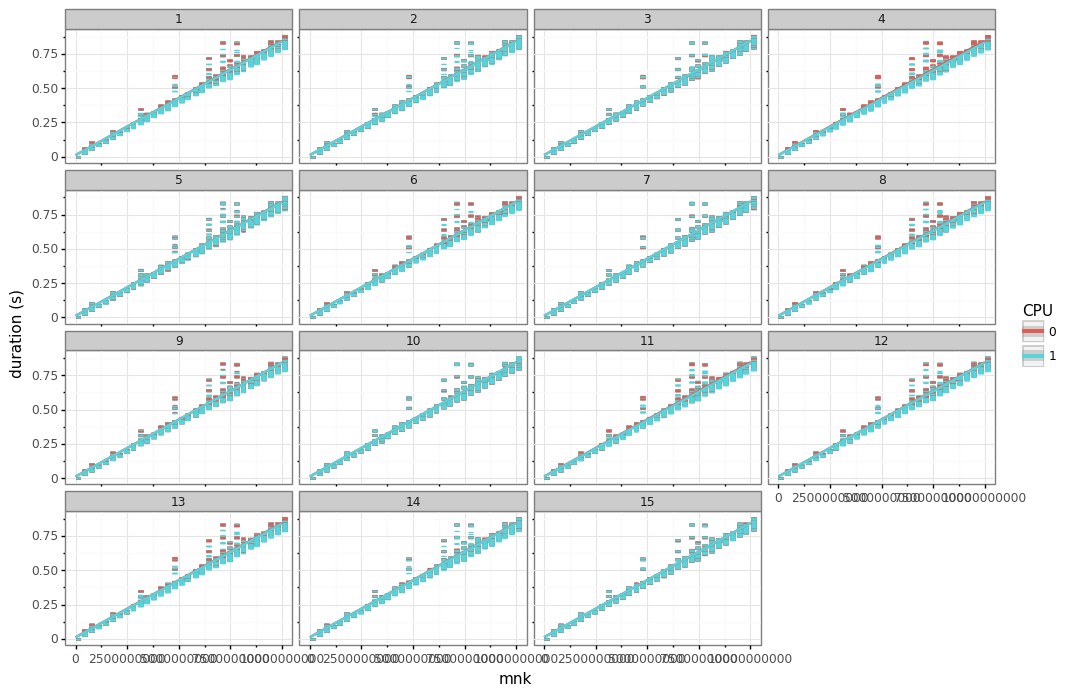

<ggplot: (-9223363292253043666)>

In [4]:
ggplot(df) +\
    aes(x='mnk', y='duration', color='factor(cpu)', group='cpu_id') +\
    geom_point(shape=1) +\
    geom_smooth(method='lm') +\
    facet_wrap('node') +\
    ylab('duration (s)') +\
    labs(color="CPU") +\
    theme_bw()

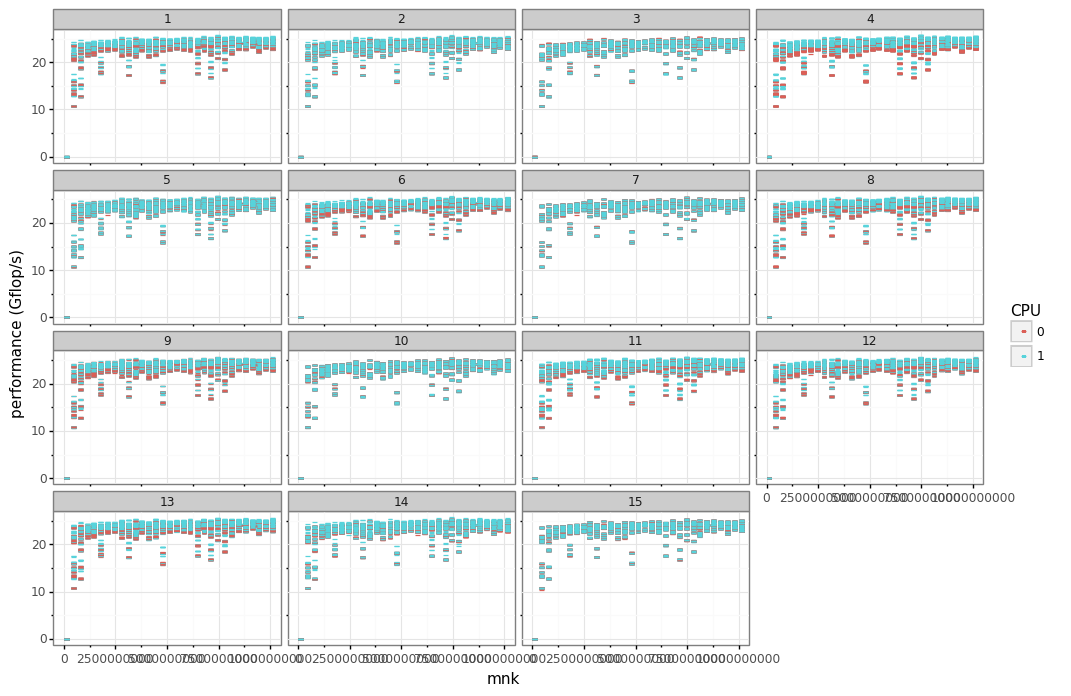

<ggplot: (8744592202672)>

In [5]:
ggplot(df) +\
    aes(x='mnk', y='gflops', color='factor(cpu)', group='cpu_id') +\
    geom_point(shape=1) +\
    facet_wrap('node') +\
    ylab('performance (Gflop/s)') +\
    labs(color="CPU") +\
    theme_bw()

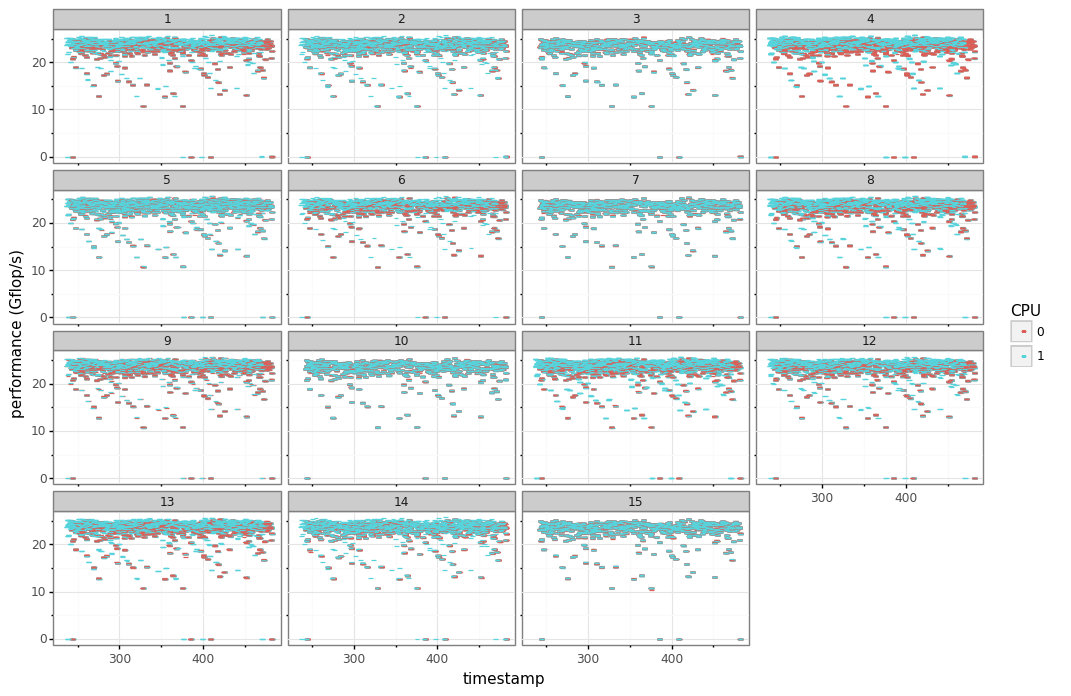

<ggplot: (8744585159165)>

In [6]:
ggplot(df) +\
    aes(x='timestamp', y='gflops', color='factor(cpu)', group='cpu_id') +\
    geom_point(shape=1) +\
    facet_wrap('node') +\
    ylab('performance (Gflop/s)') +\
    labs(color='CPU') +\
    theme_bw()

In [7]:
monitoring = pandas.concat([ae.read_monitoring(f) for f in archives])
monitoring['date'] = pandas.to_datetime(monitoring['start_time'], unit='s').astype(str)
for date in monitoring['date'].unique():
    monitoring.loc[monitoring['date'] == date, 'real_start_time'] = monitoring[monitoring['date'] == date]['timestamp'].min()
monitoring['start_exp'] -= monitoring['real_start_time']
monitoring['stop_exp'] -= monitoring['real_start_time']
monitoring['timestamp'] -= monitoring['real_start_time']
monitoring['cpu_id'] = monitoring['node'].astype(str) + ':' + monitoring['cpu'].astype(str)
print(len(monitoring))
monitoring.head()

72930


,timestamp,cluster,node,jobid,start_time,expfile_hash,value,cpu,core,kind,start_exp,stop_exp,date,real_start_time,cpu_id
0,0.000000,chetemi,1,1751940,1591777040,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,2.399938,0,0,frequency,623.082711,1412.039381,2020-06-10 08:17:20,1.591785e+09,1:0
1,10.020324,chetemi,1,1751940,1591777040,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,1.200439,0,0,frequency,623.082711,1412.039381,2020-06-10 08:17:20,1.591785e+09,1:0
2,20.036950,chetemi,1,1751940,1591777040,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,2.399938,0,0,frequency,623.082711,1412.039381,2020-06-10 08:17:20,1.591785e+09,1:0
3,30.051941,chetemi,1,1751940,1591777040,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,2.399938,0,0,frequency,623.082711,1412.039381,2020-06-10 08:17:20,1.591785e+09,1:0
4,40.063926,chetemi,1,1751940,1591777040,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,2.399938,0,0,frequency,623.082711,1412.039381,2020-06-10 08:17:20,1.591785e+09,1:0


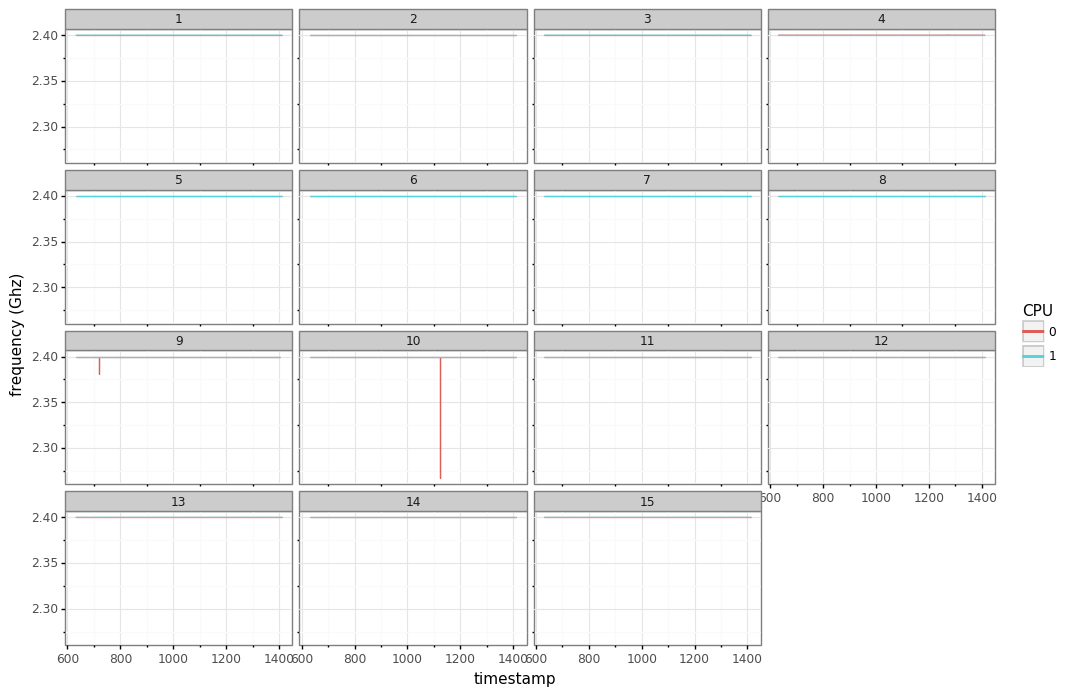

<ggplot: (8744592697152)>

In [8]:
ggplot(monitoring[(monitoring['kind'] == 'frequency') & (monitoring['timestamp'] > monitoring['start_exp']) & (monitoring['timestamp'] < monitoring['stop_exp'])]) +\
    aes(x='timestamp', y='value', color='factor(cpu)', group='cpu_id') +\
    geom_line() +\
    facet_wrap('node') +\
    ylab('frequency (Ghz)') +\
    labs(color='CPU') +\
    theme_bw()

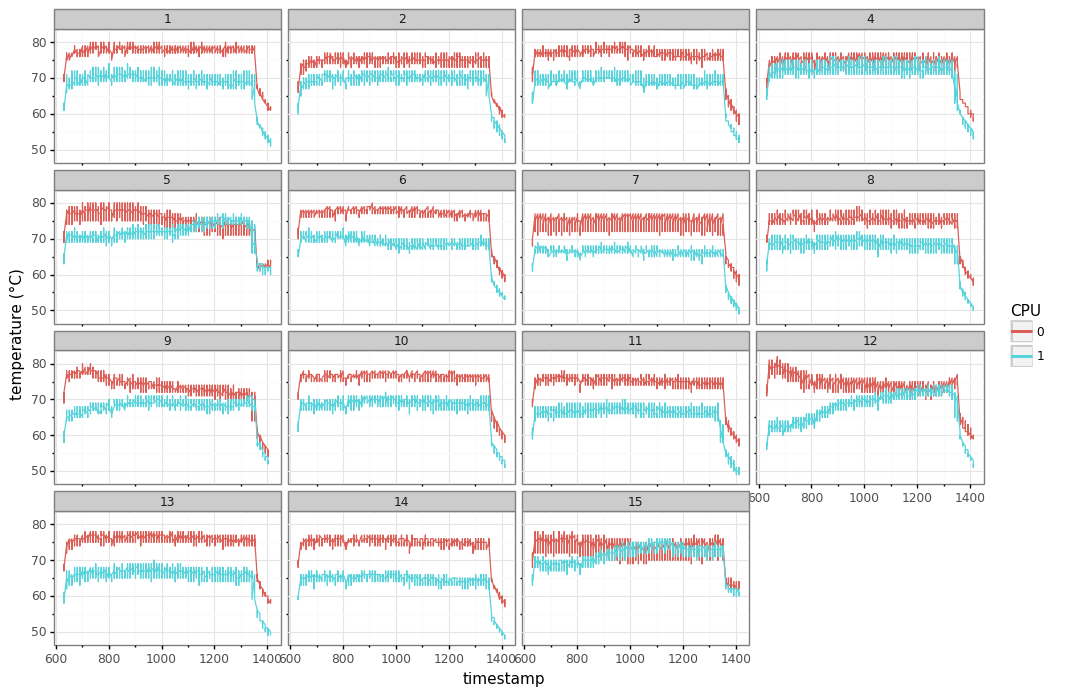

<ggplot: (-9223363292262021148)>

In [9]:
ggplot(monitoring[(monitoring['kind'] == 'temperature') & (monitoring['timestamp'] > monitoring['start_exp']) & (monitoring['timestamp'] < monitoring['stop_exp'])]) +\
    aes(x='timestamp', y='value', color='factor(cpu)', group='cpu_id') +\
    geom_line() +\
    facet_wrap('node') +\
    ylab('temperature (°C)') +\
    labs(color='CPU') +\
    theme_bw()

In [10]:
import re
reg = re.compile('power_package-(?P<cpu_id>[0-9]+)(_(?P<sub_group>[a-z]+))?')
reg.fullmatch('power_package-1').groupdict()

{'cpu_id': '1', 'sub_group': None}

In [11]:
import numpy
import re

def melt_power(df, idcol):
    reg = re.compile('power_package-(?P<cpu_id>[0-9]+)(_(?P<sub_group>[a-z]+))?')
    result = []
    columns = list(df.columns)
    for col in columns:
        match = reg.fullmatch(col)
        if match is None:
            continue
        tmp = df[idcol].copy()
        tmp['value'] = df[col]
        tmp['CPU'] = int(match.groupdict()['cpu_id'])
        tmp['subgroup'] = str(match.groupdict()['sub_group'])
        result.append(tmp)
    return pandas.concat(result)

def read_monitoring_power(archive_name, columns=None):
    '''
    Read the durations of a BLAS calibration in an archive.
    '''
    csv_name = 'monitoring.csv'
    df = ae.read_archive_csv_enhanced(archive_name, csv_name, columns=columns)
    df['timestamp'] = pandas.to_datetime(df['timestamp'])
    columns = ['timestamp', 'cluster', 'node', 'jobid', 'start_time', 'expfile_hash']
    power = melt_power(df, columns)
    power['timestamp'] = power['timestamp'].astype(numpy.int64) / 10 ** 9
    power['timestamp'] = power['timestamp'] - power['timestamp'].min()
    return power

power = pandas.concat([read_monitoring_power(f) for f in archives])
for jobid in power['jobid'].unique():
    for col in ['start_exp', 'stop_exp']:
        val = monitoring[monitoring['jobid'] == jobid][col].unique()
        assert len(val) == 1
        power.loc[power['jobid'] == jobid, col] = val
power.head()

,timestamp,cluster,node,jobid,start_time,expfile_hash,value,CPU,subgroup,start_exp,stop_exp
0,0.000000,chetemi,1,1751940,1591777040,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,38.543945,1,None,623.082711,1412.039381
1,10.020324,chetemi,1,1751940,1591777040,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,48.769196,1,None,623.082711,1412.039381
2,20.036950,chetemi,1,1751940,1591777040,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,22.527349,1,None,623.082711,1412.039381
3,30.051941,chetemi,1,1751940,1591777040,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,52.815295,1,None,623.082711,1412.039381
4,40.063926,chetemi,1,1751940,1591777040,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,58.128010,1,None,623.082711,1412.039381


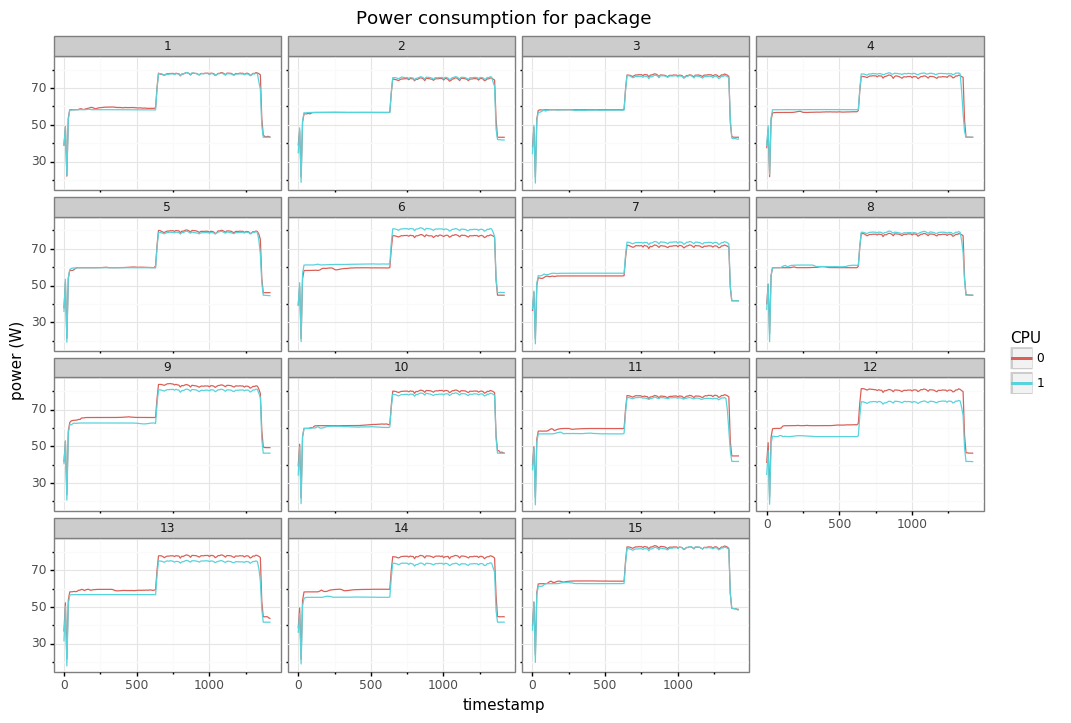

<ggplot: (-9223363292270494001)>


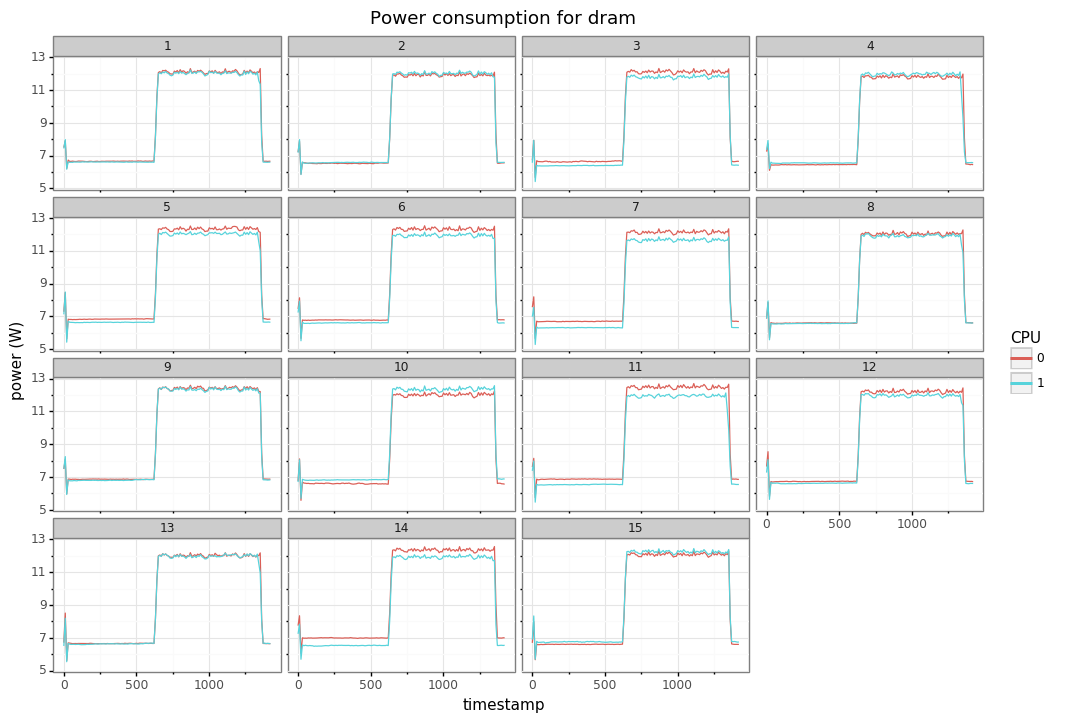

<ggplot: (8744601251911)>


In [12]:
for subgroup in power['subgroup'].unique():
    plot = ggplot(power[(power['subgroup'] == subgroup)]) +\
        aes(x='timestamp', y='value', color='factor(CPU)') +\
        geom_line() +\
        facet_wrap('node') +\
        ylab('power (W)') +\
        labs(color='CPU') +\
        theme_bw() +\
        ggtitle(f'Power consumption for {subgroup if subgroup != "None" else "package"}')
    print(plot)

In [13]:
df['timestamp'].describe()

count    163500.000000
mean        356.183818
std          69.888336
min         233.408875
25%         294.490049
50%         357.681304
75%         416.993088
max         480.540860
Name: timestamp, dtype: float64

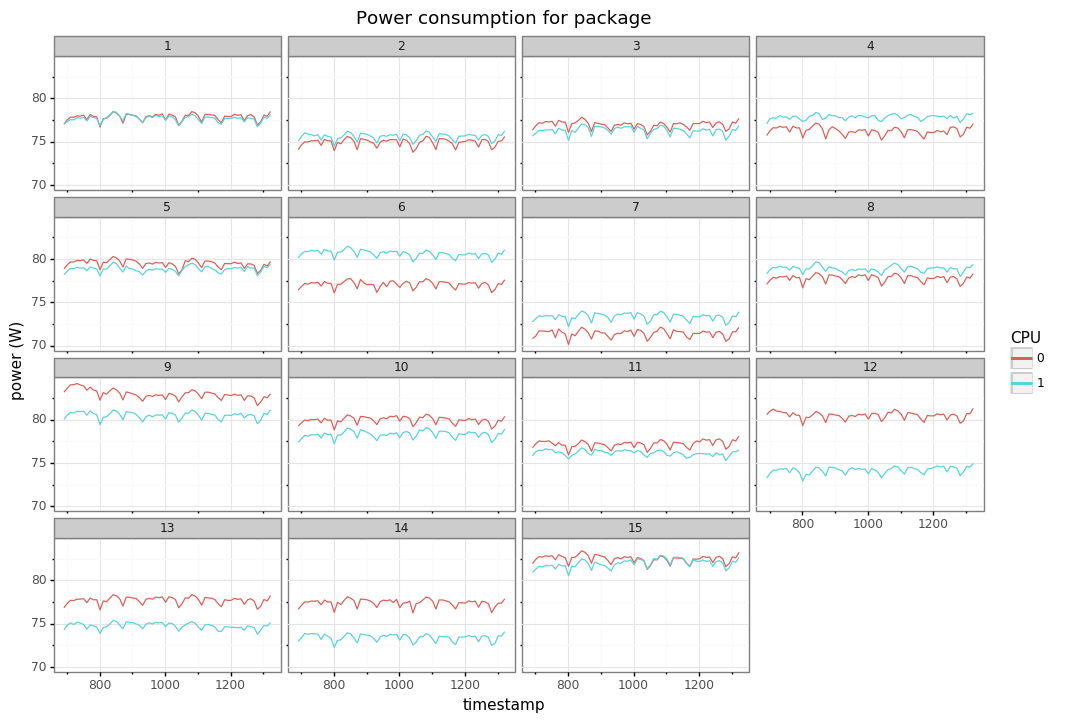

<ggplot: (8744600206021)>


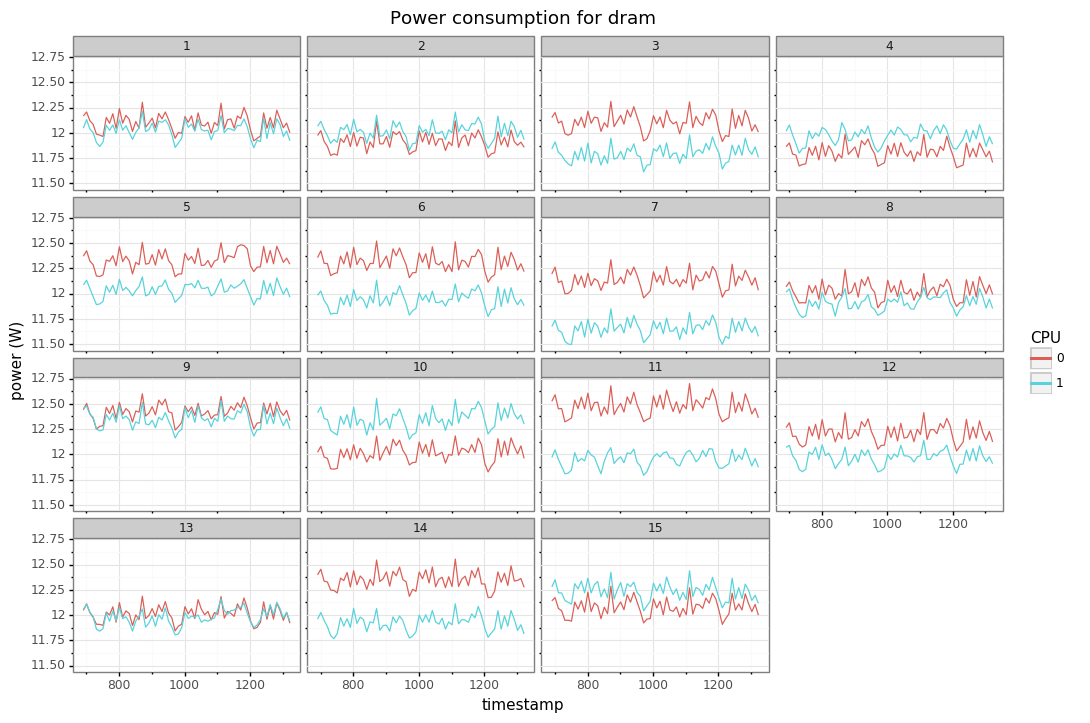

<ggplot: (8744599993394)>


In [14]:
for subgroup in power['subgroup'].unique():
    plot = ggplot(power[(power['subgroup'] == subgroup) & (power['timestamp'] > power['start_exp']+60) & (power['timestamp'] < power['stop_exp']-90)]) +\
        aes(x='timestamp', y='value', color='factor(CPU)') +\
        geom_line() +\
        facet_wrap('node') +\
        ylab('power (W)') +\
        labs(color='CPU') +\
        theme_bw() +\
        ggtitle(f'Power consumption for {subgroup if subgroup != "None" else "package"}')
    print(plot)